In [ ]:
from fpl_auto import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
d = data.fpl_data('data', '2022-23')


In [ ]:
# What points did each team score?
season = '2023-24'
# Initalise a dictionary to store the points for each team
points = {}

for i in range(0,33):
    week_data = d.get_gw_data(season, i + 1)
    # drop everything but points and team
    week_data = week_data[['team', 'total_points']]
    # iterate through the pd dataframe and add the points to the dictionary per team
    for index, row in week_data.iterrows():
        team = row['team']
        points[team] = points.get(team, 0) + row['total_points']
    
# Order the dictionary by points
points = dict(sorted(points.items(), key=lambda item: item[1], reverse=True))

# Plot the points
fig, ax = plt.subplots()
ax.bar(points.keys(), points.values())
ax.set_ylabel('Points')
ax.set_xlabel('Team')
ax.set_title(f'Points per team in the {season} season')
plt.xticks(rotation=90)


In [ ]:
# What is the average points per player?
seasons = ['2020-21', '2021-22', '2022-23']
# Initialize a dictionary to store the average points for each position
season_avg_points = {}
for season in seasons:
    points = {}
    players = {}
    for i in range(0, 38):
        week_data = d.get_gw_data(season, i + 1)
        # Drop everything but points and position
        week_data = week_data[['position', 'total_points', 'minutes']]
        # Exclude players who played less than 60 minutes
        week_data = week_data[week_data['minutes'] > 0]
        # Iterate through the pd dataframe and add the points and count the players per position
        for index, row in week_data.iterrows():
            position = row['position']
            if position == 'GKP':
                position = 'GK'
            points[position] = points.get(position, 0) + row['total_points']
            players[position] = players.get(position, 0) + 1
    # Calculate the average points per player for each position
    avg_points = {pos: points[pos] / players[pos] for pos in points}
    season_avg_points[season] = avg_points


In [ ]:
fig, ax = plt.subplots()
width = 0.25
positions = ['FWD', 'MID', 'DEF', 'GK']  # Order the positions
x = np.arange(len(positions))
for i, season in enumerate(season_avg_points.keys()):
    # Get the values for the ordered positions
    values = [season_avg_points[season][pos] for pos in positions]
    ax.bar(x + i * width, values, width, label=season)
ax.set_ylabel('Points')
ax.set_xlabel('Position')
ax.set_title('Points per position in the 2020-21, 2021-22 and 2022-23 seasons')
ax.set_xticks(x + width)
ax.set_xticklabels(positions)
ax.legend()
ax.set_ylim(bottom=0.8)  # Set the minimum y-axis value to 0.8
plt.show()

In [ ]:
# What points did each player score?
seasons = ['2020-21', '2021-22', '2022-23', '2023-24']

def plot_p_vs_v(season):
    # Initialize variables to store the sum of points and values
    total_points = {}
    total_value = {}
    player_positions = {}
    upper_bound = 38
    if season == '2023-24':
        upper_bound = 24
    for i in range(0, upper_bound):
        week_data = d.get_gw_data(season, i+1)
        # Drop everything but points, cost, and position
        week_data = week_data[['total_points', 'value', 'position']]

        # combine index in the dataframe
        week_data = week_data.reset_index()
        # Iterate through the pd dataframe and add the points, cost, and position to the dictionaries per player
        for index, row in week_data.iterrows():
            player = row['name']
            points = row['total_points']
            cost = row['value']
            position = row['position']
            # Sum the points and values separately
            # if points = 0 or cost = 0, skip
            total_points[player] = total_points.get(player, 0) + points
            total_value[player] = total_value.get(player, 0) + cost
            player_positions[player] = position
        
    # Calculate the average cost and average points for each player
    average_cost = {player: total_value[player] / 38 for player in total_value}
    average_points = {player: total_points[player] / 38 for player in total_points}

    # Plot the average cost vs average points with player positions as colors
    fig, ax = plt.subplots(figsize=(10, 8))  # Increase the height to 8
    positions = set(player_positions.values())
    colors = ['red', 'blue', 'green', 'orange', 'purple']  # Removed yellow color
    for position in positions:
        x = [average_cost[player] for player in average_cost if player_positions[player] == position]
        y = [average_points[player] for player in average_points if player_positions[player] == position]
        ax.scatter(x, y, label=position, color=colors.pop(0))
        # Annotate top 10 points with player names
        top_10_players = sorted(total_points, key=total_points.get, reverse=True)[:5]
        for player in top_10_players:
            if player_positions[player] == position:
                ax.annotate(player, (average_cost[player], average_points[player]), xytext=(5, 5), textcoords='offset points')
    ax.set_ylabel('Average Points')
    ax.set_xlabel('Average Cost')
    ax.set_title(f'Average Cost vs Average Points for players in the {season} season')
    ax.legend(loc='lower right')
    ax.set_xlim(left=0, right=165)  # Set the minimum x-axis value to 0
    plt.show()

for season in seasons:
    plot_p_vs_v(season)

In [ ]:
from fpl_auto import data 
import pandas as pd
import numpy as np
import json

# Load data
d = data.fpl_data('data', '2023-24')
fpl_api = d.api_to_json()
# find all players that have a chance_of_playing that is not 100
players = fpl_api['elements']
players = [player for player in players if player['chance_of_playing_next_round'] != 100 and player['chance_of_playing_next_round'] != None]
# create a dataframe from the players
df = pd.DataFrame(players)
# merge the first_name and second_name columns
df['name'] = df['first_name'] + ' ' + df['second_name']
df = df[['name', 'chance_of_playing_next_round', 'chance_of_playing_this_round', 'news']]
# print the dataframe
print(df)

# save the dataframe to a tsv file
df.to_csv(f'injury_list_gw{d.get_recent_gw()}.tsv', sep='\t', index=False)


In [ ]:
from fpl_auto import team

t = team.team('2023-24', 1)
t.initial_team_generator()
print(f'xP {t.team_xp(include_subs=True)} including subs')
print(f'P {t.team_p()}')

In [ ]:
from fpl_auto import data

d = data.fpl_data('data', '2023-24')

training_data = d.get_training_data('2023-24', 1)

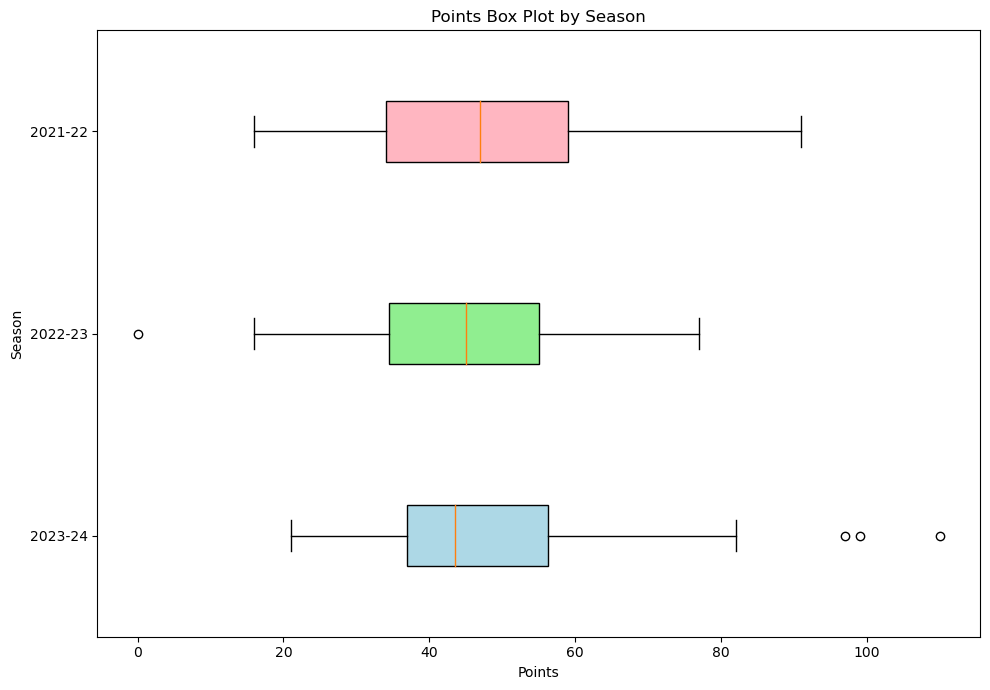

In [2]:
from fpl_auto import evaluate as eval


s1 = [62, 34, 38, 37, 43, 37, 67, 38, 48, 99, 54, 34, 44, 44, 63, 35, 82, 47, 33, 21, 62, 39, 110, 31, 38, 72, 41, 36, 43, 47, 52, 52, 57, 26, 43, 21, 97, 47]
s2 = [39, 63, 54, 55, 31, 44, 0, 33, 69, 77, 45, 19, 45, 36, 41, 34, 33, 16, 53, 62, 55, 38, 46, 42, 62, 65, 54, 29, 29, 32, 47, 41, 54, 59, 57, 58, 52, 43]
s3 = [49, 39, 91, 16, 56, 44, 64, 43, 38, 79, 34, 33, 38, 43, 59, 34, 47, 52, 49, 34, 65, 68, 70, 53, 21, 78, 22, 25, 21, 17, 52, 65, 47]
seasons = ['2023-24', '2022-23', '2021-22']
points = [s1, s2, s3]


eval.box_plot_by_season(points, seasons)